In [1]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten
from keras.layers import Dense, Activation, Dropout, Reshape, Permute, BatchNormalization, LeakyReLU, ELU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from torchvision.models import resnet50, ResNet50_Weights
import tf_harmonic

data_directory = pathlib.Path("filtered")

2024-05-04 18:01:03.615802: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 18:01:04.276221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
    except ValueError as e:
        pass
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16000)]
            )  # Set memory limit to 1024 MB
    except RuntimeError as e:
        print(e)
else:
    print('oops')

Num GPUs Available:  1
GPU is available


2024-05-04 18:01:06.672140: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 18:01:06.672922: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 18:01:06.672966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
img_height,img_width=180,180
batch_size=32
num_folds = 5
epochs = 100

list_ds = tf.data.Dataset.list_files(str(data_directory/'*/*'), shuffle=True)
file_paths = np.array([str(path) for path in data_directory.glob('*/*.jpg')]) 
np.random.seed(123)
np.random.shuffle(file_paths)

image_count = len(list(list_ds))

fold_size = len(file_paths) // num_folds
folds = [file_paths[i * fold_size:(i + 1) * fold_size] for i in range(num_folds)]

class_names = np.array(sorted([item.name for item in data_directory.glob('*') if item.is_dir()]))

def process_path(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2]
    label = tf.where(class_names == label)[0][0]
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    # One-hot encode the label
    label = tf.one_hot(label, depth=150)  # Assuming you have 149 classes
    return img, label
def get_dataset(file_paths):
    list_ds = tf.data.Dataset.from_tensor_slices(file_paths)
    list_ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    return list_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

2024-05-04 18:01:06.692354: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 18:01:06.692799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 18:01:06.692920: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 18:01:06.858798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 18:01:06.858822: I tensorflow/core/common_runtime/gpu/gpu

In [4]:
def get_model():
  resnet50(weights=ResNet50_Weights.DEFAULT)
  # for layer in base_model.layers:
    # layer.trainable = False
  # model = Sequential()
  base_model = tf.keras.applications.ResNet50(
      include_top=False,
      input_shape=(180, 180, 3), 
      pooling='avg',
      weights='imagenet'
  )
  for layer in base_model.layers:
    layer.trainable = False
  # base_model.trainable = False
  model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(150, activation='softmax')
  ])
  return model
get_model = tf_harmonic.get_model

In [5]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.0001,
  decay_steps=10000,
  decay_rate=0.9)


In [6]:
histories = []
for fold_index in range(num_folds):
    optimzer = Adam(learning_rate=lr_schedule)
    val_files = folds[fold_index]
    train_files = np.concatenate([folds[i] for i in range(num_folds) if i != fold_index])

    train_ds = get_dataset(train_files)
    val_ds = get_dataset(val_files)

    model = get_model()
    model.compile(optimizer=optimzer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=25)
    model_checkpoint = ModelCheckpoint(f'models/best_model_{fold_index}.keras', 
                                       monitor='val_accuracy', save_best_only=True)
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping, model_checkpoint])
    model.save(f'models/model_fold_{fold_index}.keras')
    histories.append(history)

Epoch 1/100


I0000 00:00:1714870889.190540 1830253 service.cc:145] XLA service 0x7f2ec4004850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714870889.191003 1830253 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-05-04 18:01:29.902066: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-04 18:01:32.946254: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1714870897.985594 1834071 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_16224', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1714870898.221434 1834069 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_16224', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:

  1/167 ━━━━━━━━━━━━━━━━━━━━ 2:07:25 46s/step - accuracy: 0.0000e+00 - loss: 7.1020

I0000 00:00:1714870916.186179 1830253 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.0633 - loss: 5.4551

I0000 00:00:1714870948.561630 1834566 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1749', 244 bytes spill stores, 244 bytes spill loads



167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 213ms/step - accuracy: 0.0638 - loss: 5.4491 - val_accuracy: 0.0195 - val_loss: 6.1462
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.6031 - loss: 1.7616 - val_accuracy: 0.0804 - val_loss: 4.8006
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9143 - loss: 0.4844 - val_accuracy: 0.3659 - val_loss: 3.0825
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.9886 - loss: 0.1395 - val_accuracy: 0.5702 - val_loss: 2.0517
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9950 - loss: 0.0525 - val_accuracy: 0.7265 - val_loss: 1.3071
Epoch 6/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.9976 - loss: 0.0347 - val_accuracy: 0.8024 - val_loss: 0.8591
Epoch 7/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9987 - loss: 0.0201 - val_accuracy: 0.8152 - val_loss: 0.7720
Epoch 8/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9994 - loss: 0.0144 - val

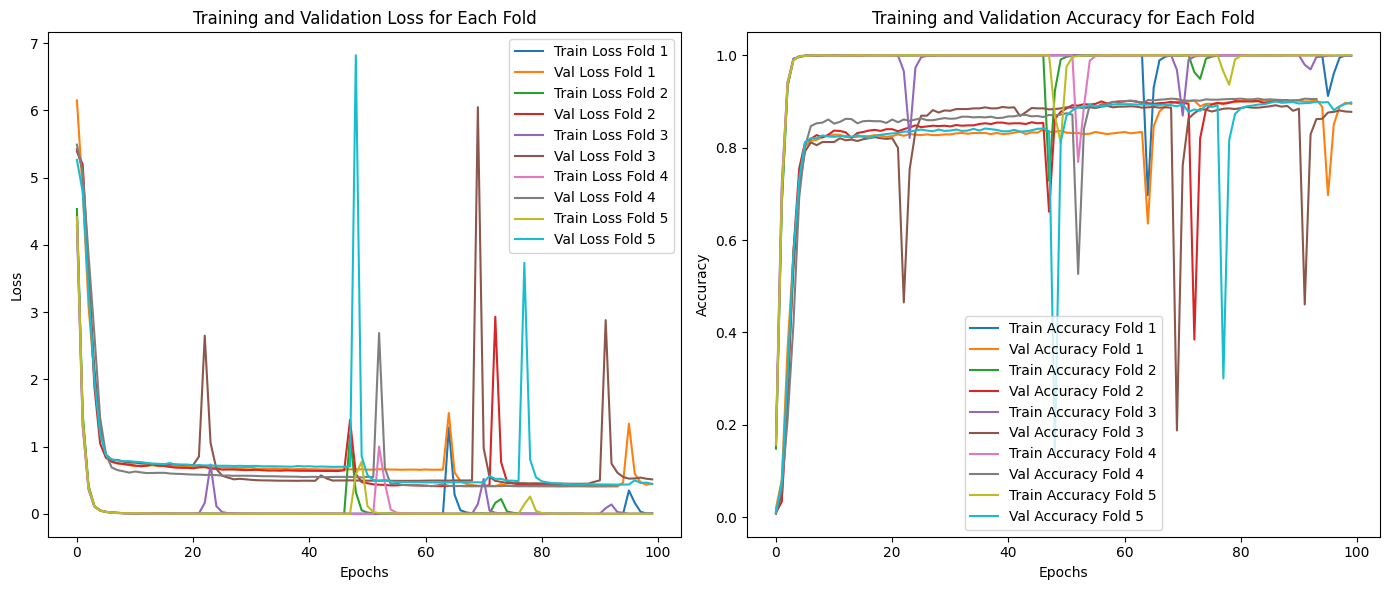

In [9]:

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Loss Fold {i+1}')
plt.title('Training and Validation Loss for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Train Accuracy Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy Fold {i+1}')
plt.title('Training and Validation Accuracy for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjust layout
plt.show()  # Display the plots


In [11]:
import csv
with open('model_histories.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Epoch', 'Loss', 'Validation Loss', 'Accuracy', 'Validation Accuracy'])

    # Write the data for each history
    for i, history in enumerate(histories):
        for epoch in range(len(history.history['loss'])):
            row = [
                epoch + 1,  # Epoch number
                history.history['loss'][epoch],  # Loss
                history.history['val_loss'][epoch],  # Validation Loss
                history.history['accuracy'][epoch],  # Accuracy
                history.history['val_accuracy'][epoch]  # Validation Accuracy
            ]
            writer.writerow(row)